📍 Step-1: Import Libraries & Set Limits

In this step, we import the required Python libraries and define the allowed ranges for all parameters in the problem.
These limits ensure that the values of θ, M, X, and t always stay within the valid range.

Parameter Limits (as per question):
| Parameter | Meaning                         | Valid Range              |
| --------- | ------------------------------- | ------------------------ |
| θ (theta) | Rotation angle of the curve     | 0° to 50° (not included) |
| M         | Exponential growth/decay factor | −0.05 to +0.05           |
| X         | Horizontal shift of curve       | 0 to 100                 |
| t         | Parameter of the curve          | 6 to 60                  |


 We also create a small helper function that keeps a value within these limits.

In [ ]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import math, os, json

# Parameter Limits (Constraints given in problem)

LIMITS = {
    "theta_deg": (0.000001, 49.999999),  # Rotation angle θ must be between 0° and 50° (not inclusive)
    "M": (-0.049999999, 0.049999999),    # M must be between -0.05 and 0.05
    "X": (0.000001, 99.999999),          # X must be between 0 and 100
    "t": (6.0, 60.0)                     # t lies between 6 and 60
}


# Function to Keep a value inside limits or within range

def keep_within_range(value, min_val, max_val):
    """
    Ensures 'value' always stays within the given allowed range [min_val, max_val].
    If value goes beyond, it is clipped to nearest boundary.
    """
    return max(min_val, min(value, max_val))


📍 Step-2: Load the Data (xy_data.csv)

In this step, we load the dataset that contains the (x, y) points of the curve.
The CSV file must be in the same folder and must have two columns: x and y.

This function:

✅ Checks if the file exists

✅ Loads the CSV

✅ Ensures the required columns are present

✅ Returns the data as a NumPy array

In [ ]:
# Step 2: Function to load the dataset (xy_data.csv)

def load_dataset(file_name="xy_data.csv"):

    if not os.path.exists(file_name):
        raise FileNotFoundError(
            f"The file '{file_name}' was not found. "
            "Please place it in the same folder as this script."
        )

    data = pd.read_csv(file_name)

    if 'x' not in data.columns or 'y' not in data.columns:
        raise ValueError(
            "The CSV file must contain two columns: 'x' and 'y'. "
            f"Found columns: {list(data.columns)}"
        )

    print(f"Successfully loaded '{file_name}'")
    print(f"Total Data Points Loaded: {len(data)}")

    return data[['x', 'y']].to_numpy()


xy_points = load_dataset("xy_data.csv")
print("Shape of Loaded Data (rows, columns):", xy_points.shape)


Successfully loaded 'xy_data.csv'
Total Data Points Loaded: 1500
Shape of Loaded Data (rows, columns): (1500, 2)


📍 Step-3: Convert (x, y) → (t, r)

We convert the original data points from the XY-plane into (t, r) coordinates.

t represents how far each point lies along the main direction of the curve

r represents how much the point deviates sideways from that direction

This transformation makes it easier to estimate the parameters θ, M, and X.

    Converts the given (x, y) data into:
        - t values : distance along the rotated axis (main curve direction)
        - r values : perpendicular distance from the main curve

    The (x, y) values are first shifted by X and 42, then rotated using θ
    to obtain the corresponding (t, r) values. Only valid t values (6 to 60)
    are kept for further calculations.

In [ ]:
# Step 3: Convert the (x, y) points into (t, r) coordinates


def convert_xy_to_tr(theta_rad, X_shift, xy_array):

    cos_theta = math.cos(theta_rad)
    sin_theta = math.sin(theta_rad)

    x_adj = xy_array[:, 0] - X_shift
    y_adj = xy_array[:, 1] - 42.0

    # Compute t ->  Formula: t = (x_adj * cosθ) + (y_adj * sinθ)
    t_values = (cos_theta * x_adj) + (sin_theta * y_adj)

    # Only keep valid t values within given range: 6 < t < 60
    valid_mask = (t_values > LIMITS["t"][0]) & (t_values < LIMITS["t"][1])
    t_values = t_values[valid_mask]
    x_adj = x_adj[valid_mask]
    y_adj = y_adj[valid_mask]


    # Compute r ->  r = (-sinθ * x_adj) + (cosθ * y_adj)
    r_values = (-sin_theta * x_adj) + (cos_theta * y_adj)

    return t_values, r_values


📍 Step-4: Estimate M for Given (θ, X)

In this step, we calculate the value of M for a selected pair of parameters θ (theta) and X.

Once the (x, y) data is converted into (t, r) form (in Step-3), we use the model equation:

  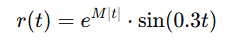

Rearranging to find M:

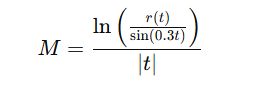

✅ What this function does:


    Estimate the value of M for a given (theta_radians, x_shift) pair.

    The model states:
        r_observed ≈ exp(M * |t|) * sin(0.3 * t)

    So,
        M ≈ ln(r_observed / sin(0.3t)) / |t|

    Steps:
    1. Convert (x, y) to (t, r_observed)
    2. Filter only valid values (safe to divide and log)
    3. Compute M for each valid sample, take median for robustness
    4. Clamp M to allowed range
    5. Calculate error (MAE) for evaluation of this M

    This step helps us find how well a given (θ, X) pair fits the data.



In [ ]:
# Step 4: Estimate M Value for a Given (θ, X)

def estimate_M_for(theta_radians, x_shift, xy_points, epsilon=1e-9):

    t_values, r_observed_values = convert_xy_to_tr(theta_radians, x_shift, xy_points)

    if t_values.size == 0:
        return None, float("inf")

    sinus_term = np.sin(0.3 * t_values)

    valid_indices = (np.abs(sinus_term) > epsilon) & (r_observed_values / sinus_term > 0)

    if not np.any(valid_indices):
        return None, float("inf")

    valid_t = t_values[valid_indices]
    valid_ratio = r_observed_values[valid_indices] / sinus_term[valid_indices]

    M_values_each_point = np.log(valid_ratio) / np.abs(valid_t)
    M_estimated = float(np.median(M_values_each_point))
    M_estimated = keep_within_range(M_estimated, LIMITS["M"][0], LIMITS["M"][1])

    r_predicted = np.exp(M_estimated * np.abs(t_values)) * np.sin(0.3 * t_values)
    mae_error = float(np.mean(np.abs(r_observed_values - r_predicted)))

    return M_estimated, mae_error


📍 Step-5: Coarse Search for (θ, X)

We scan a grid of angles θ (in degrees, converted to radians) and shifts X.
For each pair, we estimate M (Step-4) and compute the error (MAE).
We keep the combination with the lowest MAE as the initial best guess.

    Performs a coarse grid search to find a good starting estimate of:
        - theta (rotation angle in radians)
        - X shift (horizontal shift)
        - M (estimated using Step-4)

    We check values at intervals of theta_step_degrees and x_step_size,
    and keep the combination that results in the lowest MAE error.


In [ ]:
# Step 5: Coarse Search for the Best (theta, X) Combination


def coarse_search_for_best_parameters(xy_points, theta_step_degrees=0.5, x_step_size=0.5):

    theta_values_radians = np.deg2rad(np.arange(0.5, 50.0, theta_step_degrees))
    x_shift_values = np.arange(0.5, 100.0, x_step_size)

    best_result = {
        "theta_radians": None,
        "x_shift": None,
        "M_estimated": None,
        "mae_error": float("inf")
    }

    # Try each (theta, X) pair in the grid
    for theta_radians in theta_values_radians:
        for x_shift in x_shift_values:

            M_estimated, mae_error = estimate_M_for(theta_radians, x_shift, xy_points)

            # If this combination gives a smaller error, update best result
            if mae_error < best_result["mae_error"]:
                best_result.update({
                    "theta_radians": theta_radians,
                    "x_shift": x_shift,
                    "M_estimated": M_estimated,
                    "mae_error": mae_error
                })

    return best_result


best_initial_guess = coarse_search_for_best_parameters(xy_points)

print("\nCoarse Search Result (Initial Best Guess)")
print("------------------------------------------")
print(f"Best Theta (radians) : {best_initial_guess['theta_radians']:.6f}")
print(f"Best Theta (degrees) : {np.rad2deg(best_initial_guess['theta_radians']):.4f}°")
print(f"Best X Shift Value   : {best_initial_guess['x_shift']:.4f}")
print(f"Estimated M Value     : {best_initial_guess['M_estimated']:.6f}")
print(f"MAE Error             : {best_initial_guess['mae_error']:.8f}")
print("------------------------------------------\n")



Coarse Search Result (Initial Best Guess)
------------------------------------------
Best Theta (radians) : 0.523599
Best Theta (degrees) : 30.0000°
Best X Shift Value   : 55.0000
Estimated M Value     : 0.030000
MAE Error             : 0.00001407
------------------------------------------



📍 Step-6: Local Refinement of (θ, X)

We take the best values of θ and X found from the Coarse Search and try to improve them further.

For this, we make small random adjustments around the current best values and check if the changes reduce the MAE error.
If the new values perform better, we update them.
This helps us fine-tune the parameters for more accurate results.

    Performs a local refinement to improve the coarse best values of:
        - theta (rotation angle in radians)
        - X shift (horizontal shift)
        - M (re-estimated each time)

    We make small random changes to theta and X and keep the change only if it
    improves the MAE score. This helps reach a more accurate result after the
    coarse search.


In [ ]:
# Step 6: Local Refinement - Fine-tunes the best (theta, X) from coarse search

def refine_parameters_locally(best_params, xy_points, num_iterations=1500,
                              theta_std_degrees=0.1, x_std_shift=0.2, random_seed=0):

    rng = np.random.default_rng(random_seed)
    # Start with the coarse search result as the "current best"
    current_params = dict(best_params)

    for _ in range(num_iterations):
        # 1. Generate small random variation for theta (in radians)
        theta_candidate = current_params["theta_radians"] + np.deg2rad(
            rng.normal(0, theta_std_degrees)
        )
        theta_candidate = keep_within_range(theta_candidate,
                                            LIMITS["theta_deg"][0] * math.pi/180,
                                            LIMITS["theta_deg"][1] * math.pi/180)

        # 2. Generate small random variation for X shift
        x_shift_candidate = current_params["x_shift"] + rng.normal(0, x_std_shift)
        x_shift_candidate = keep_within_range(x_shift_candidate,
                                              LIMITS["X"][0], LIMITS["X"][1])

        # 3. Evaluate M & error for this new candidate
        M_candidate, mae_candidate_error = estimate_M_for(theta_candidate,
                                                          x_shift_candidate, xy_points)

        # 4. If the new guess is better, update current best
        if mae_candidate_error < current_params["mae_error"]:
            current_params.update({
                "theta_radians": theta_candidate,
                "x_shift": x_shift_candidate,
                "M_estimated": M_candidate,
                "mae_error": mae_candidate_error
            })

    return current_params


best_refined_params = refine_parameters_locally(best_initial_guess, xy_points)

print("\nRefined Parameters After Local Optimization")
print("--------------------------------------------")
print(f"Theta (radians) : {best_refined_params['theta_radians']:.6f}")
print(f"Theta (degrees) : {np.rad2deg(best_refined_params['theta_radians']):.4f}°")
print(f"X Shift Value   : {best_refined_params['x_shift']:.4f}")
print(f"Estimated M     : {best_refined_params['M_estimated']:.6f}")
print(f"MAE Error       : {best_refined_params['mae_error']:.8f}")
print("--------------------------------------------\n")



Refined Parameters After Local Optimization
--------------------------------------------
Theta (radians) : 0.523599
Theta (degrees) : 30.0000°
X Shift Value   : 55.0000
Estimated M     : 0.030000
MAE Error       : 0.00001407
--------------------------------------------



📍 Step-7: Calculate Final Error in (x, y) Space

After we get the refined values of θ, X, and M, we now check how well the model matches the original data in the actual XY plane.

To do this, we:

Reconstruct the predicted (x, y) points from the fitted model

Compare them with the original (x, y) values

Calculate the error using:

L1 Error → Average of |Δx| + |Δy|

RMSE → Root Mean Square Error in XY plane

This tells us how accurately the model fits the real data.

    
    Reconstructs the predicted x(t) and y(t) using the final (θ, X, M) values,
    then compares them with the original data points to measure accuracy.

    The following metrics are computed:
        - L1_xy   : Mean Absolute Error in X and Y
        - RMSE_xy : Root Mean Square Error (2D distance)
    Returns a dictionary with these values.


In [ ]:
# Step 7: Reconstruct (x, y) from (t, r_pred) and compute L1 / RMSE in xy-space

def compute_final_metrics(refined_params, xy_points):

    theta_radians = refined_params["theta_radians"]
    x_shift       = refined_params["x_shift"]
    M_estimated   = refined_params["M_estimated"]

    cos_theta = math.cos(theta_radians)
    sin_theta = math.sin(theta_radians)

    x_centered = xy_points[:, 0] - x_shift
    y_centered = xy_points[:, 1] - 42.0

    t_values = (cos_theta * x_centered) + (sin_theta * y_centered)

    # Only keep valid t in (6, 60)
    valid_mask = (t_values > LIMITS["t"][0]) & (t_values < LIMITS["t"][1])
    t_values   = t_values[valid_mask]
    x_centered = x_centered[valid_mask]
    y_centered = y_centered[valid_mask]

    r_observed = (-sin_theta * x_centered) + (cos_theta * y_centered)
    r_predicted = np.exp(M_estimated * np.abs(t_values)) * np.sin(0.3 * t_values)

    x_predicted = x_shift + (t_values * cos_theta) - (r_predicted * sin_theta)
    y_predicted = 42.0    + (t_values * sin_theta) + (r_predicted * cos_theta)

    x_observed = x_shift + (t_values * cos_theta) - (r_observed * sin_theta)
    y_observed = 42.0    + (t_values * sin_theta) + (r_observed * cos_theta)

    # Compute L1 (mean absolute in x and y) and RMSE (2D)
    L1_xy   = float(np.mean(np.abs(x_observed - x_predicted) + np.abs(y_observed - y_predicted)))
    RMSE_xy = float(np.sqrt(np.mean((x_observed - x_predicted)**2 + (y_observed - y_predicted)**2)))

    return {"L1_xy": L1_xy, "RMSE_xy": RMSE_xy, "n": int(len(t_values))}


📍 Step-8: Display Final Results

In this step, we print the final optimized values of θ, M, and X obtained after refinement.
We also show the parametric equations with the fitted values substituted, so we can directly use them in our report or submission.

    Displays the final optimized values of θ, M, and X, and prints the
    parametric equations with these values substituted inside them.

    This helps to clearly present the final model that best fits the data.

In [ ]:
# Step 8: Display Final Results

# Extract fitted values
theta_rad = best_refined_params["theta_radians"]
theta_deg = float(np.rad2deg(theta_rad))
M_value   = best_refined_params["M_estimated"]
X_value   = best_refined_params["x_shift"]

# Print Output
print("\nFINAL OPTIMIZED PARAMETERS")
print("------------------------------------------------------")
print(f"θ (theta)          : {theta_rad:.6f} radians")
print(f"θ (theta)          : {theta_deg:.4f}°")
print(f"M (Growth factor)  : {M_value:.6f}")
print(f"X (Shift)          : {X_value:.6f}")
print("------------------------------------------------------")

print("\nPARAMETRIC EQUATIONS (WITH VALUES SUBSTITUTED)")
print("------------------------------------------------------")
print(f"x(t) = t·cos({theta_rad:.6f}) - exp({M_value:.6f}·|t|)·sin(0.3t)·sin({theta_rad:.6f}) + {X_value:.6f}")
print(f"y(t) = 42 + t·sin({theta_rad:.6f}) + exp({M_value:.6f}·|t|)·sin(0.3t)·cos({theta_rad:.6f})")
print("------------------------------------------------------")



FINAL OPTIMIZED PARAMETERS
------------------------------------------------------
θ (theta)          : 0.523599 radians
θ (theta)          : 30.0000°
M (Growth factor)  : 0.030000
X (Shift)          : 55.000000
------------------------------------------------------

PARAMETRIC EQUATIONS (WITH VALUES SUBSTITUTED)
------------------------------------------------------
x(t) = t·cos(0.523599) - exp(0.030000·|t|)·sin(0.3t)·sin(0.523599) + 55.000000
y(t) = 42 + t·sin(0.523599) + exp(0.030000·|t|)·sin(0.3t)·cos(0.523599)
------------------------------------------------------


📍 Step-9: Visualize the Fitted Model with 4 Plots

To clearly understand how well the model fits the data, we create a 2×2 plot showing:

Original Data Points

Predicted Curve using fitted values

Overlay of Data vs Predicted Curve

Residuals (Error) vs t

This gives a complete visual comparison between the actual dataset and the model performance.

    Creates a 2×2 plot showing:
        (1) Original data points
        (2) Smooth predicted curve for t ∈ [6, 60]
        (3) Overlay of actual vs predicted curve
        (4) Residuals (difference between observed and predicted points)

    This helps us see how well the fitted curve matches the actual data.


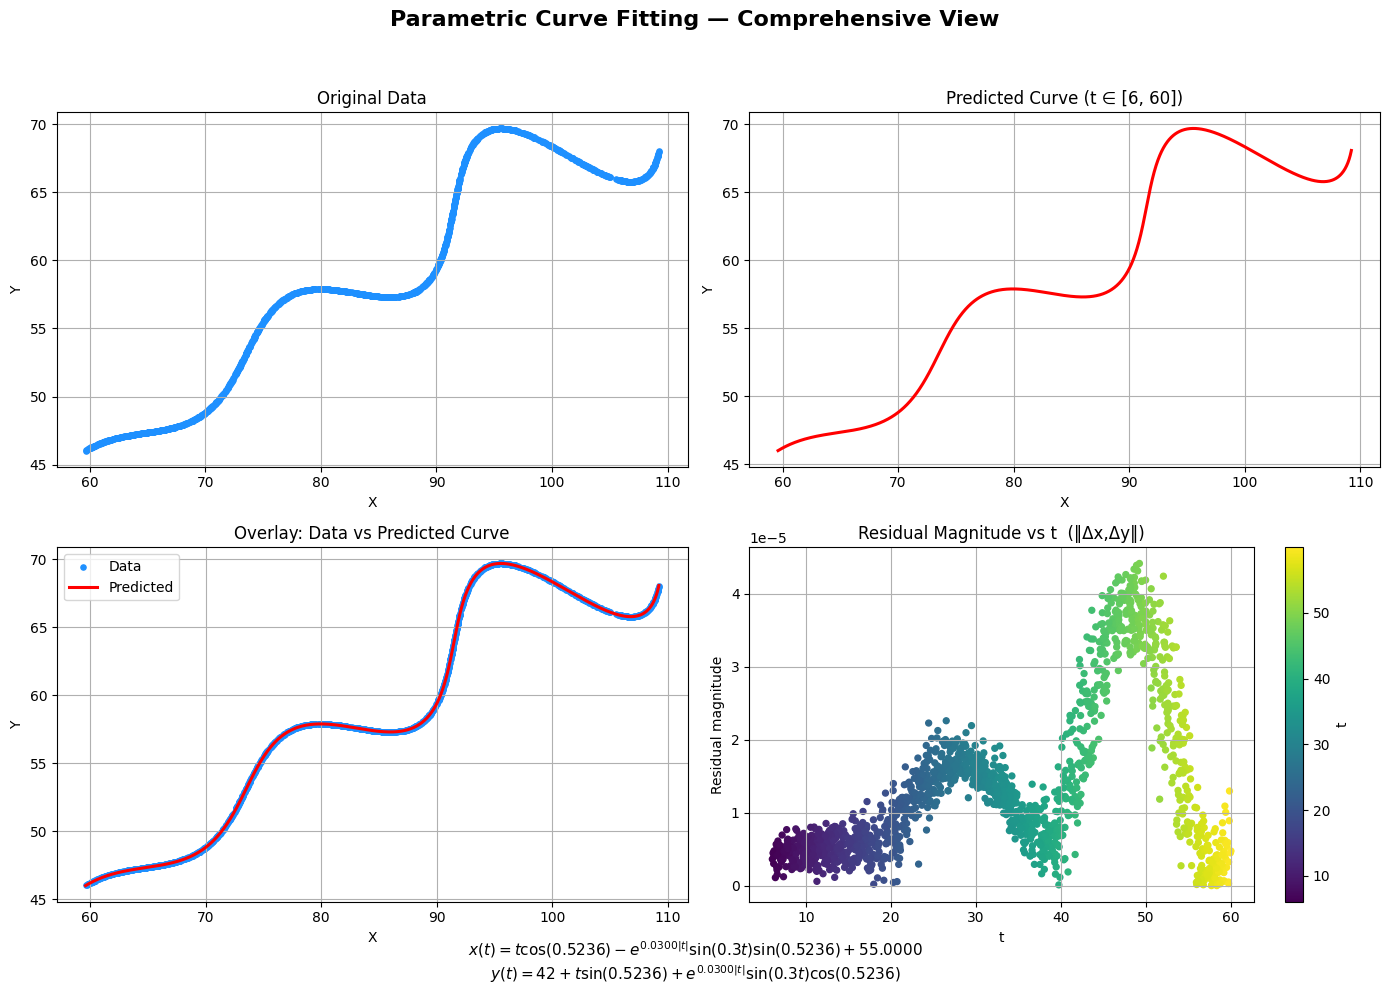

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2x2_full(theta_radians, M_estimated, x_shift, xy_points, num_samples=1000, save_path=None):

    # --- Smooth predicted curve for visualization ---
    t_smooth = np.linspace(6, 60, num_samples)
    r_smooth = np.exp(M_estimated * np.abs(t_smooth)) * np.sin(0.3 * t_smooth)
    x_curve  = x_shift + t_smooth * np.cos(theta_radians) - r_smooth * np.sin(theta_radians)
    y_curve  = 42 + t_smooth * np.sin(theta_radians) + r_smooth * np.cos(theta_radians)

    cos_th, sin_th = np.cos(theta_radians), np.sin(theta_radians)
    x_centered = xy_points[:, 0] - x_shift
    y_centered = xy_points[:, 1] - 42.0

    # t for each data point
    t_data = cos_th * x_centered + sin_th * y_centered
    # keep only valid t ∈ (6, 60)
    valid = (t_data > 6) & (t_data < 60)
    t_valid = t_data[valid]

    r_obs_valid = -sin_th * x_centered[valid] + cos_th * y_centered[valid]
    r_pred_valid = np.exp(M_estimated * np.abs(t_valid)) * np.sin(0.3 * t_valid)

    x_pred_valid = x_shift + t_valid * cos_th - r_pred_valid * sin_th
    y_pred_valid = 42 + t_valid * sin_th + r_pred_valid * cos_th
    x_obs_valid  = x_shift + t_valid * cos_th - r_obs_valid * sin_th
    y_obs_valid  = 42 + t_valid * sin_th + r_obs_valid * cos_th

    dx = x_obs_valid - x_pred_valid
    dy = y_obs_valid - y_pred_valid
    residual_mag = np.sqrt(dx**2 + dy**2)

    # --- Figure layout ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Parametric Curve Fitting — Comprehensive View", fontsize=16, fontweight="bold")

    # (1) Original data
    ax = axes[0, 0]
    ax.scatter(xy_points[:, 0], xy_points[:, 1], s=14, color="dodgerblue")
    ax.set_title("Original Data")
    ax.set_xlabel("X"); ax.set_ylabel("Y")
    ax.grid(True)

    # (2) Predicted curve (smooth)
    ax = axes[0, 1]
    ax.plot(x_curve, y_curve, color="red", linewidth=2.2)
    ax.set_title("Predicted Curve (t ∈ [6, 60])")
    ax.set_xlabel("X"); ax.set_ylabel("Y")
    ax.grid(True)

    # (3) Overlay
    ax = axes[1, 0]
    ax.scatter(xy_points[:, 0], xy_points[:, 1], s=14, color="dodgerblue", label="Data")
    ax.plot(x_curve, y_curve, color="red", linewidth=2.2, label="Predicted")
    ax.set_title("Overlay: Data vs Predicted Curve")
    ax.set_xlabel("X"); ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)

    # (4) Residuals vs t (for valid points)
    ax = axes[1, 1]
    sc = ax.scatter(t_valid, residual_mag, c=t_valid, cmap="viridis", s=18)
    ax.set_title("Residual Magnitude vs t  (‖Δx,Δy‖)")
    ax.set_xlabel("t")
    ax.set_ylabel("Residual magnitude")
    ax.grid(True)
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("t")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # show the fitted formula with substituted values
    formula_text = (
        rf"$x(t)=t\cos({theta_radians:.4f}) - e^{{{M_estimated:.4f}|t|}}\sin(0.3t)\sin({theta_radians:.4f}) + {x_shift:.4f}$" "\n"
        rf"$y(t)=42 + t\sin({theta_radians:.4f}) + e^{{{M_estimated:.4f}|t|}}\sin(0.3t)\cos({theta_radians:.4f})$"
    )
    plt.figtext(0.5, 0.01, formula_text, ha="center", fontsize=11)

    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()


plot_2x2_full(theta_radians, M_estimated, x_shift, xy_points, save_path=None)
